**Первый этап: Распознавание лица**


In [38]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


Все необходимые импорты

In [0]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

Чтение изображения

In [40]:
img = cv2.imread('/gdrive/My Drive/images/13.jpg')
im = np.array(Image.open('/gdrive/My Drive/images/13.jpg'))
print(type(img))
print(type(im))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Выделение лица

In [0]:
crop_img = []
# Load the cascade
face_cascade = cv2.CascadeClassifier('/gdrive/My Drive/opencv/data/haarcascades_cuda/haarcascade_frontalface_default.xml')
# Convert into grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
# Draw rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 1)
    crop_img.append(img[y:y+h, x:x+w])

Показ результата

(394, 700, 3)


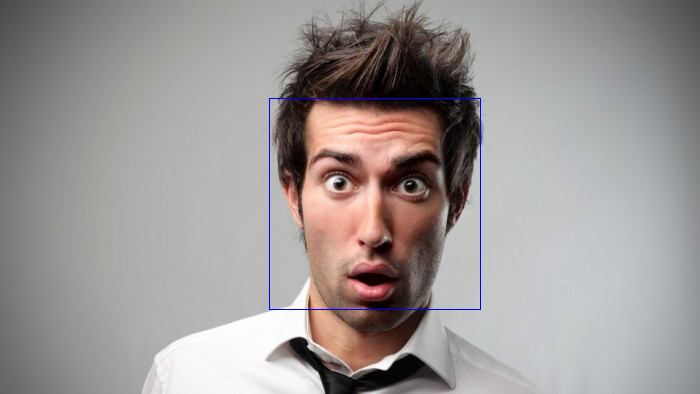

1


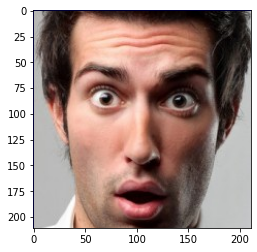

In [42]:
# Display the output
print(img.shape)
cv2_imshow(img)
print(len(crop_img))
#for i in range(len(crop_img)):
plt.imshow(cv2.cvtColor(crop_img[0], cv2.COLOR_BGR2RGB))
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Приведению к стандартному размеру для модели

(200, 200, 3)


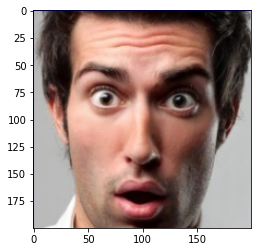

In [43]:
image = cv2.resize(crop_img[0], (200, 200))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
print(image.shape)

**Второй этап: Распознавание эмоций**

In [0]:
from tensorflow.keras.models import model_from_json
import numpy
import os

Загрузка модели

In [45]:
json_file = open('/gdrive/My Drive/DiplomWork/Third/VGG19ForEmotionDetection.json')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights('/gdrive/My Drive/DiplomWork/Third/VGG19ForEmotionDetection_weights.h5')
print("Loaded model from disk")

Loaded model from disk


Скомпилируем модель

In [46]:
from tensorflow.keras import regularizers, optimizers
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

loaded_model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 6, 6, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                1179712   
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                

Подадим изображение модели для распознования

{'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happiness': 4, 'neutral': 5, 'sadness': 6, 'surprise': 7}

In [47]:
image1 = image / 255
result = loaded_model.predict(image1.reshape((1, image.shape[0], image.shape[1], 3)))
print("%f -> anger" %(result[0][0]))
print("%f -> contempt" %(result[0][1]))
print("%f -> disgust" %(result[0][2]))
print("%f -> fear" %(result[0][3]))
print("%f -> happiness" %(result[0][4]))
print("%f -> neutral" %(result[0][5]))
print("%f -> sadness" %(result[0][6]))
print("%f -> surprise" %(result[0][7]))

0.013112 -> anger
0.001260 -> contempt
0.005025 -> disgust
0.007268 -> fear
0.089800 -> happiness
0.854613 -> neutral
0.009209 -> sadness
0.019714 -> surprise


**Третий этап: Анализ распознавания**

Вывод первого слоя

In [49]:
from tensorflow import keras
first_output = keras.Model(inputs=loaded_model.input, outputs=loaded_model.layers[1].output)
first_output.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19_input (InputLayer)     [(None, 200, 200, 3)]     0         
_________________________________________________________________
vgg19 (Model)                (None, 6, 6, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
Total params: 20,024,384
Trainable params: 0
Non-trainable params: 20,024,384
_________________________________________________________________


In [50]:
result2 = first_output.predict(image1.reshape((1, image.shape[0], image.shape[1], 3)))
result1 = result2.reshape((6, 6, 512))
print(result1.shape)

(6, 6, 512)


In [52]:
# visualize feature maps output from each block in the vgg model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
model = VGG19(include_top=False, input_shape=(200,200,3))
# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)


80142336/80134624 [==============================] - 3s 0us/step


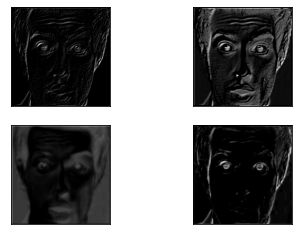

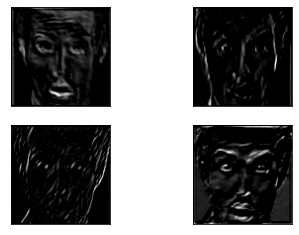

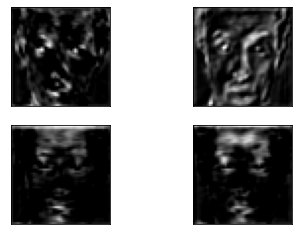

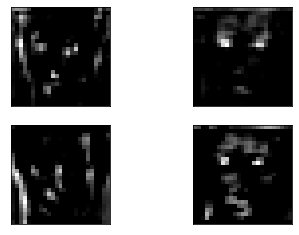

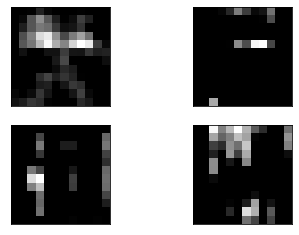

In [53]:
# load the image with the required shape
img = image
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
square = 2
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = pyplot.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
			ix += 1
	# show the figure
	pyplot.show()